In [1]:
import numpy as np

# %matplotlib notebook
from tqdm import tqdm
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
from tqdm import tqdm 
rcParams['figure.figsize'] = 10, 15

### Plot Functions

In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[2,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[2,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

In [3]:
def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

In [4]:
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
    ax.legend()

### Random Rotation and Translation

In [5]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)
R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Brute Force Data Correspondence 

In [6]:
def get_correspondences(P, Q):
    p_size, q_size = P.shape[1], Q.shape[1]
    correspondences = list()
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

#### R = Rz * Ry * Rx

In [7]:
def RotationMatrix(phi, theta, shi): #RzRyRz phi->x, theta->y, shi->z
    return Matrix(
                    [
                        [cos(shi) * cos(theta), cos(shi) * sin(theta) * sin(phi) - sin(shi) * cos(phi), cos(shi) * sin(theta) * cos(phi) + sin(shi) * sin(phi)], 
                        [sin(shi) * cos(theta), sin(shi) * sin(theta) * sin(phi) + cos(shi) * cos(phi), sin(shi) * sin(theta) * cos(phi) - cos(shi) * sin(phi)],
                        [-sin(theta), cos(theta) * sin(phi), cos(theta) * cos(phi)]
                    ]
                 )

def R(phi, theta, shi): #RzRyRz phi->x, theta->y, shi->z
    return np.array(
                    [
                        [math.cos(shi) * math.cos(theta), math.cos(shi) * math.sin(theta) * math.sin(phi) - math.sin(shi) * math.cos(phi), math.cos(shi) * math.sin(theta) * math.cos(phi) + math.sin(shi) * math.sin(phi)], 
                        [math.sin(shi) * math.cos(theta), math.sin(shi) * math.sin(theta) * math.sin(phi) + math.cos(shi) * math.cos(phi), math.sin(shi) * math.sin(theta) * math.cos(phi) - math.cos(shi) * math.sin(phi)],
                        [-math.sin(theta), math.cos(theta) * math.sin(phi), math.cos(theta) * math.cos(phi)]
                    ]
                 )

## Calculate Jacobian And Moved Point

In [8]:
from sympy import init_printing, symbols, Matrix, cos, sin, diff
from IPython.display import display, Math, Latex, Markdown, HTML
from sympy import lambdify

init_printing(use_unicode = True)


x, y, z, phi, theta, shi, p_x, p_y, p_z= symbols('x, y, z, \\phi, \\theta, \\psi, p_x, p_y, p_z')


t = Matrix([[x], [y], [z]])
X = Matrix([x, y, z, phi, theta, shi])
p = Matrix([[p_x], [p_y], [p_z]])

_moved_point = RotationMatrix(phi, theta, shi) * p + t

_jacobian = diff(_moved_point, X).reshape(6, 3).transpose() #jacobian at point

display(Latex('Moved Point'), _moved_point)
display(Latex('Jacobian'), _jacobian)

<IPython.core.display.Latex object>

⎡pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\psi) - sin(\psi)⋅c
⎢                                                                             
⎢pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\psi)⋅sin(\theta) + cos(\phi)⋅c
⎢                                                                             
⎣                                       -pₓ⋅sin(\theta) + p_y⋅sin(\phi)⋅cos(\t

os(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + x ⎤
                                                                            ⎥
os(\psi)) + p_z⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + y⎥
                                                                            ⎥
heta) + p_z⋅cos(\phi)⋅cos(\theta) + z                                       ⎦

<IPython.core.display.Latex object>

⎡1  0  0  p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + p_z⋅(-
⎢                                                                             
⎢0  1  0  p_y⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(
⎢                                                                             
⎣0  0  1                                     p_y⋅cos(\phi)⋅cos(\theta) - p_z⋅s

sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))   -pₓ⋅sin(\theta)⋅cos(\
                                                                              
-sin(\phi)⋅sin(\psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))  -pₓ⋅sin(\psi)⋅sin(\th
                                                                              
in(\phi)⋅cos(\theta)                                                    -pₓ⋅co

psi) + p_y⋅sin(\phi)⋅cos(\psi)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\thet
                                                                              
eta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅s

In [9]:
s = (phi, theta, shi, p_x, p_y, p_z)
lambda_jacobian = lambdify(s, _jacobian, modules='numpy')

def calculate_jacobian(x, p)-> np.array:
    J = lambda_jacobian(*x.reshape(-1)[3:], *list(p))
    return np.array(J)

In [10]:
s = (x, y, z, phi, theta, shi, p_x, p_y, p_z)
calcuate_moved_point = lambdify(s, _moved_point, modules='numpy')

def calculate_error(x, p_point, q_point) -> np.array:
    x = x.reshape(-1)
    p_new = calcuate_moved_point(*x, *p_point)
    return p_new - q_point.reshape(3, 1)    

### Point to Point

In [11]:
def prepare_system(x, P, Q, correspondences, kernel=lambda distance: 1.0):
    H = np.zeros((6, 6))
    g = np.zeros((6, 1))
    chi = 0
    
    for i, j in correspondences:
        p_point, q_point = P[:, i], Q[:, j]
        e = calculate_error(x, p_point, q_point)
        weight = kernel(e)
        
        J = calculate_jacobian(x, p_point)
        H += weight * J.T.dot(J).reshape(6,6)
        g += weight * J.T.dot(e)
        
        chi += e.T * e
        
    return H, g, chi

In [12]:
def icp_least_squares(P, Q, iterations=30, kernel=lambda distance: 1.0):
    x = np.zeros((6, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    for it in tqdm( range(iterations), desc ="Iteration"):
        rot = R(*x[3:])
        t = x[0:3]
        correspondences = get_correspondences(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        
#         x[3] = math.atan2(math.sin(x[3]), math.cos(x[3])) # normalize angle
#         x[4] = math.atan2(math.sin(x[4]), math.cos(x[4]))
#         x[5] = math.atan2(math.sin(x[4]), math.cos(x[5]))
        
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(*x[3:])
        t = x[0:3]
        P_copy = rot.dot(P.copy()) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

### Point to Plane

In [13]:
def compute_normals(points, step=1):
    normals = [np.array([0, 0, 0])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        a_bar = prev_point - curr_point
        b_bar = next_point - curr_point
        normal = np.cross(a_bar, b_bar)
        normal = normal / np.linalg.norm(normal)
        normals.append(normal)  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([0, 0, 0]))
    return np.array(normals), normals_at_points

#### Normal

In [14]:
n_x, n_y, n_z = symbols(' n_x, n_y, n_z')
n = Matrix([[n_x],[n_y], [n_z]])

_error_normal = n.dot(RotationMatrix(phi, theta, shi) * p + t)

display(Latex("Point to point Jacobian: "), _error_normal)

_jacobian_normal = diff(_error_normal, X).reshape(6, 1).transpose()

display(Latex("Point to plane Jacobian: "), _jacobian_normal)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[nₓ  n_y  n_z  nₓ⋅(p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi))
 + p_z⋅(-sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))) + n_y⋅(p_y⋅(-
sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(-sin(\phi)⋅sin(\
psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))) + n_z⋅(p_y⋅cos(\phi)⋅cos(\theta) - p_
z⋅sin(\phi)⋅cos(\theta))  nₓ⋅(-pₓ⋅sin(\theta)⋅cos(\psi) + p_y⋅sin(\phi)⋅cos(\p
si)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\theta)) + n_y⋅(-pₓ⋅sin(\psi)⋅si
n(\theta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅sin(\psi)⋅cos(\phi)⋅cos(
\theta)) + n_z⋅(-pₓ⋅cos(\theta) - p_y⋅sin(\phi)⋅sin(\theta) - p_z⋅sin(\theta)⋅
cos(\phi))  nₓ⋅(-pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(-sin(\phi)⋅sin(\psi)⋅sin(\the
ta) - cos(\phi)⋅cos(\psi)) + p_z⋅(sin(\phi)⋅cos(\psi) - sin(\psi)⋅sin(\theta)⋅
cos(\phi))) + n_y⋅(pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\
psi) - sin(\psi)⋅cos(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)
⋅cos(\psi)))]

In [15]:
s = (phi, theta, shi, p_x, p_y, p_z, n_x, n_y, n_z)
lambda_normal_jacobian = lambdify(s, _jacobian_normal, modules='numpy')

def calculate_jacobian_normal(x, p, normal)-> np.array:
    J = lambda_normal_jacobian(*x.reshape(-1)[3:], *list(p), *normal)
    return np.array(J)

In [16]:
s = (x, y, z, phi, theta, shi, p_x, p_y, p_z)
calcuate_moved_point = lambdify(s, _moved_point, modules='numpy')

def calculate_error(x, p_point, q_point) -> np.array:
    x = x.reshape(-1)
    p_new = calcuate_moved_point(*x, *p_point)
    return p_new - q_point.reshape(3, 1)    

In [17]:
def prepare_system_normals(x, P, Q, correspondences, normals):
    H = np.zeros((6, 6))
    g = np.zeros((6, 1))
    chi = 0
    for (i, j), normal in zip(correspondences, normals):
        
        p_point, q_point = P[:, [i]], Q[:, [j]]
        
        e = normal.dot(calculate_error(x.reshape(-1), p_point.reshape(-1), q_point.reshape(-1)))
        
        J = calculate_jacobian_normal(x.reshape(-1), p_point.reshape(-1), normal.reshape(-1))
        H += J.T.dot(J)
        g += (J.T.reshape(6, 1)).dot(e.reshape(1, 1))
        chi += e.T * e
    return H, g, chi

In [18]:
def icp_normal(P, Q, normals, iterations=20):
    x = np.zeros((6, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_latest = P.copy()
    corresp_values = []
    for it in tqdm( range(iterations), desc ="Iteration"):
        rot = R(*x[3:])
        t = x[0:3]
        correspondences = get_correspondences(P_latest, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system_normals(x, P, Q, correspondences, normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        
#         x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        
        chi_values.append(chi.item(0)) # add error to list of errors
        x_values.append(x.copy())
        
        rot = R(*x[3:])
        t = x[0:3]
        P_latest = rot.dot(P.copy()) + t
        P_values.append(P_latest)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

### Random Point set generation P, Q

### 100 points

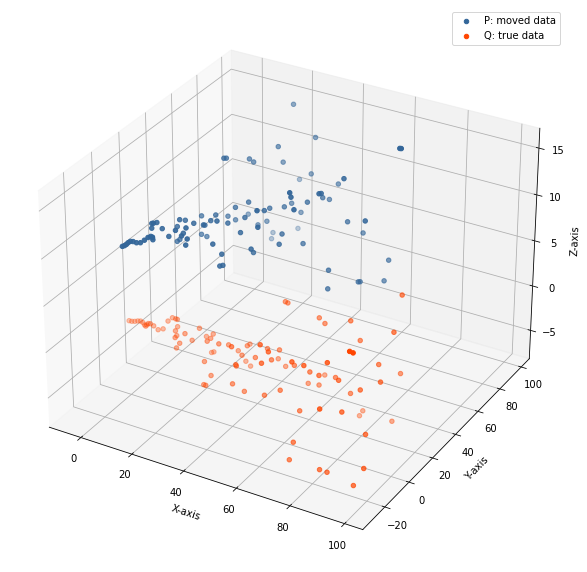

In [19]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Compute Correspondences

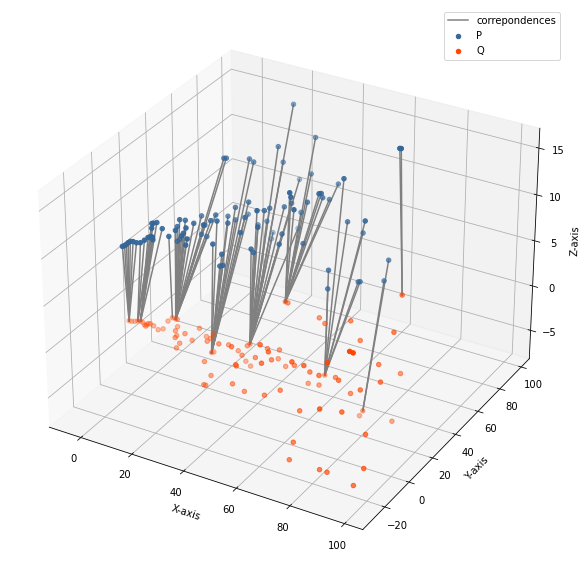

In [20]:
correspondences = get_correspondences(P, Q)
ax = plot_data(P, Q, label_1='P', label_2='Q')
draw_correspondences(P, Q, correspondences, ax)
plt.show()

#### Error for point cloud over iterations

Iteration: 100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


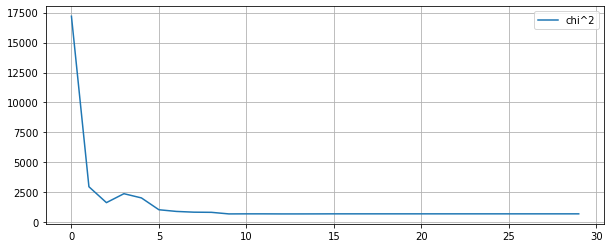

[17190.631716791147, 2975.362344322263, 1652.0161826776562, 2396.28734022782, 2045.270957890923, 1058.8511102350508, 918.6662500479421, 855.9877575173072, 843.0848201476194, 711.3475792864392, 716.6025101277586, 716.1861069543206, 710.8368450201139, 710.9611097298472, 713.2581100478277, 717.2001212704804, 717.193315302799, 717.1934773642681, 717.1934861814701, 717.193486730791, 717.1934867727878, 717.1934867767475, 717.1934867771811, 717.1934867772318, 717.1934867772379, 717.1934867772378, 717.193486777239, 717.1934867772392, 717.1934867772392, 717.1934867772393]


In [21]:
P_values, chi_values, corresp_values = icp_least_squares(P, Q)
plot_values(chi_values, label="chi^2")
print(chi_values)

#### Final Alignment

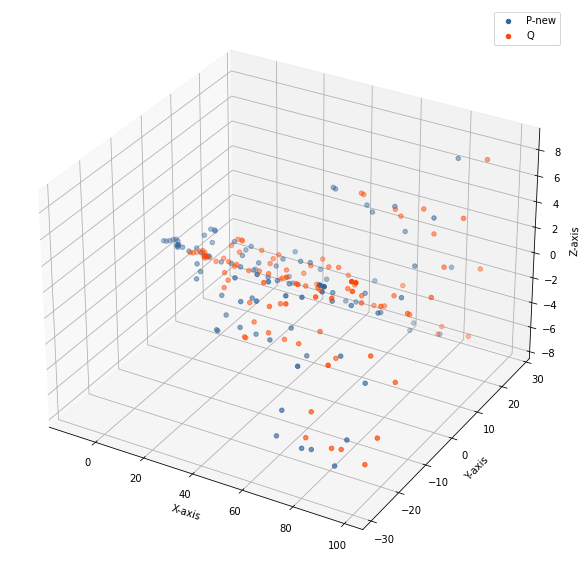

In [22]:
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()

### Point to plane
### Final Allignment

Iteration: 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


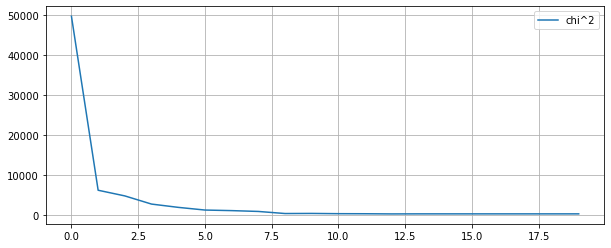

[49688.516751936724, 6189.7052205749915, 4771.444096488711, 2728.819263305013, 1908.1318333552902, 1237.700423910933, 1094.8627382469115, 887.9982712931851, 366.6962531902636, 391.0139741099635, 329.2398498453246, 312.85628153942935, 269.9846916500266, 284.12574346381405, 283.26879150078366, 283.24645091221265, 283.24597277645324, 283.2459602297112, 283.2459599001202, 283.24595989146184]


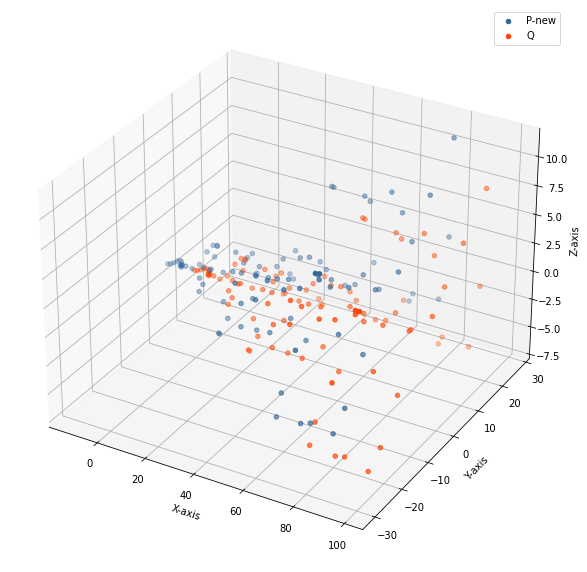

In [23]:
normals, normals_to_draw = compute_normals(Q)

P_values, chi_values, corresp_values = icp_normal(P, Q, normals)
plot_values(chi_values, label="chi^2")
print(chi_values)
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()

### 1000 points

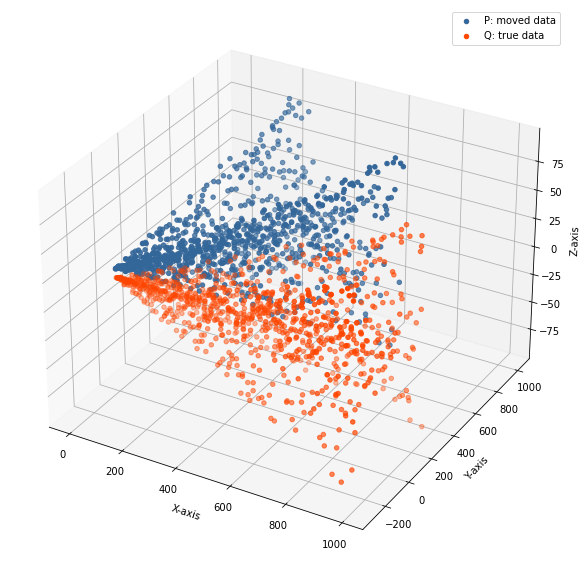

In [24]:
num_points = 1000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Compute Correspondences

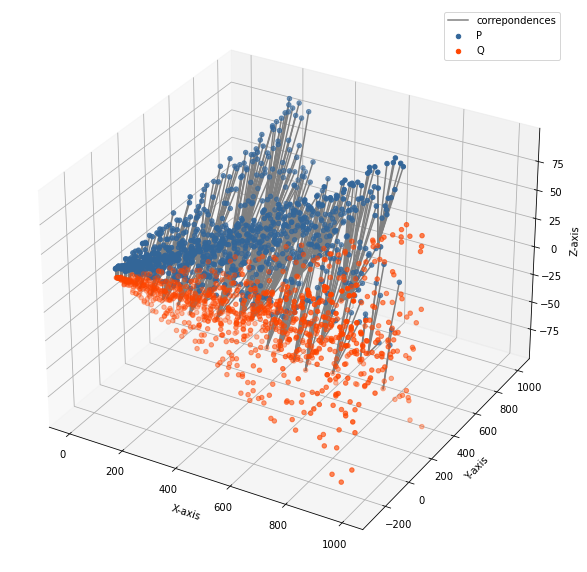

In [25]:
correspondences = get_correspondences(P, Q)
ax = plot_data(P, Q, label_1='P', label_2='Q')
draw_correspondences(P, Q, correspondences, ax)
plt.show()

#### Error for point cloud over iterations

Iteration: 100%|██████████| 30/30 [02:56<00:00,  5.90s/it]


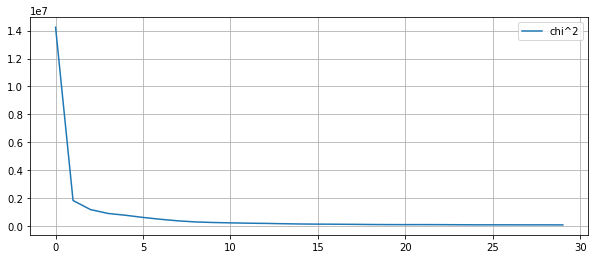

[14235794.169619847, 1849801.1362881784, 1199672.8727792224, 924131.2522563273, 794786.8592131045, 639589.4369049278, 507451.6400096927, 395582.7690360998, 317764.3922351788, 277556.3471691289, 251875.98089833156, 227844.48558535642, 213037.0299713058, 190017.79250940363, 170292.96809224793, 160568.86996089437, 154315.48367862092, 145665.6499263507, 134435.32648201706, 127923.4095923822, 125321.10914889401, 126772.88299363093, 123752.25344890801, 117800.77047068835, 111149.85996197411, 111663.54009343607, 111627.446178449, 108586.02480919585, 109412.21828042589, 104637.675952872]


In [26]:
P_values, chi_values, corresp_values = icp_least_squares(P, Q)
plot_values(chi_values, label="chi^2")
print(chi_values)

#### Final Alignment

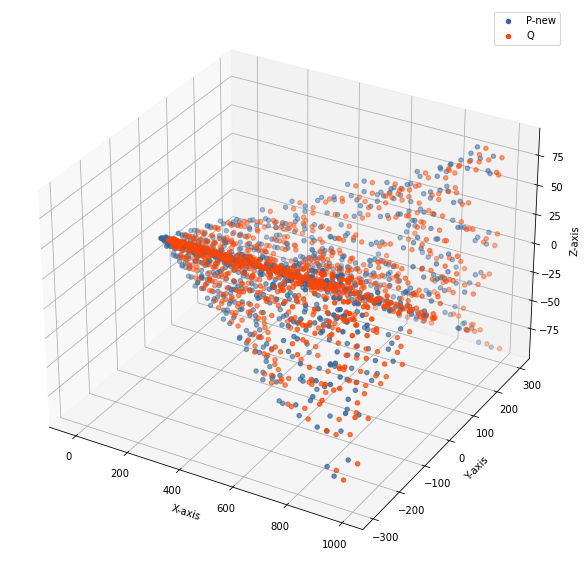

In [27]:
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()

### Point to plane 
### Final Allignment

Iteration: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


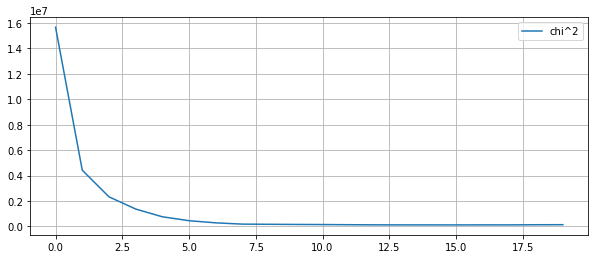

[15660687.649934318, 4421452.620304908, 2326959.633988416, 1367110.7133127586, 758019.7463296163, 449775.97506220103, 280647.233522225, 180319.17830594155, 167810.6826640809, 155585.5804268328, 146867.61476383975, 133840.8204826188, 124030.1611566188, 120940.17662743837, 120320.42836133654, 118169.02832087294, 122090.31641982435, 120519.21662845007, 131513.2691595668, 135443.87534439968]


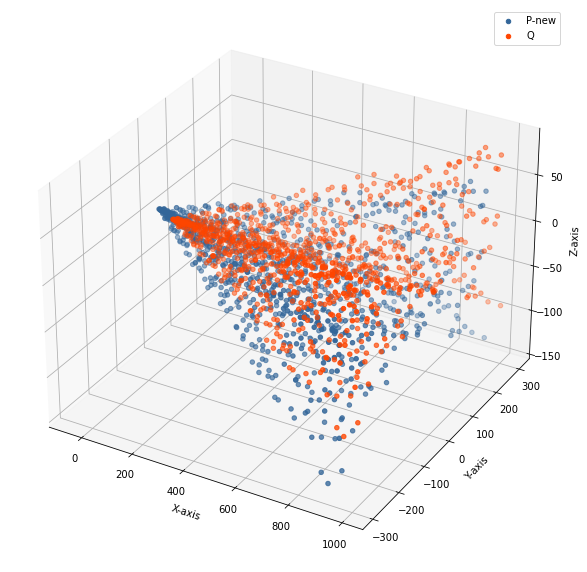

In [28]:
normals, normals_to_draw = compute_normals(Q)

P_values, chi_values, corresp_values = icp_normal(P, Q, normals)
plot_values(chi_values, label="chi^2")
print(chi_values)
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()

### 5000 points

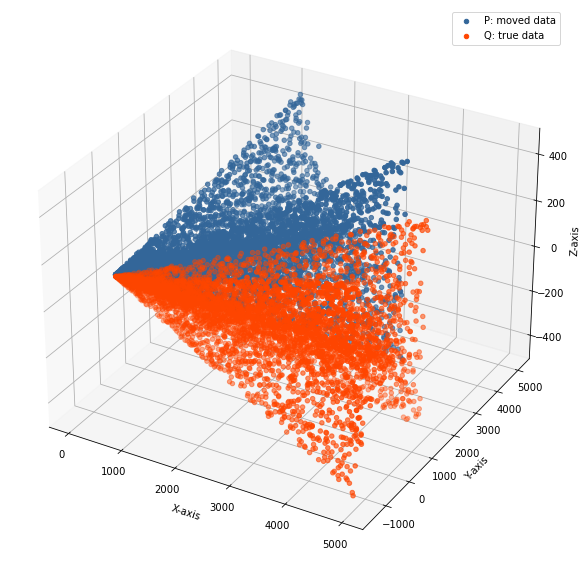

In [32]:
num_points = 5000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Compute Correspondences

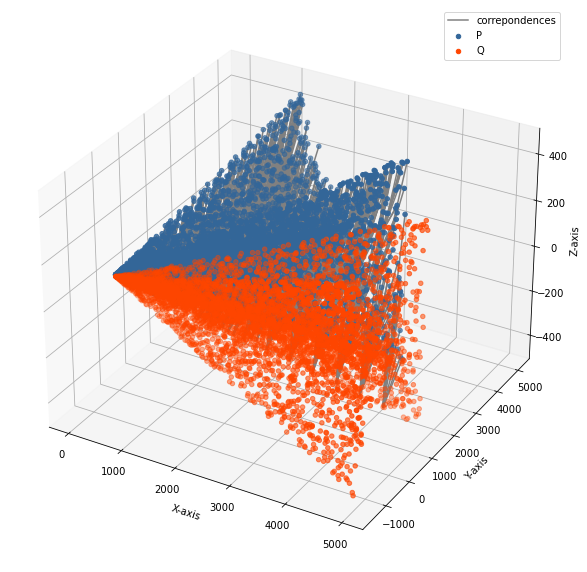

In [36]:
correspondences = get_correspondences(P, Q)
ax = plot_data(P, Q, label_1='P', label_2='Q')
draw_correspondences(P, Q, correspondences, ax)
plt.show()

#### Error for point cloud over iterations

Iteration: 100%|██████████| 30/30 [1:12:55<00:00, 145.84s/it]


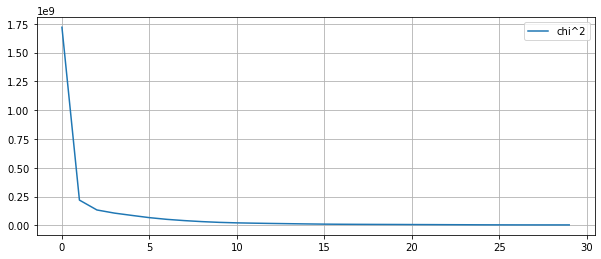

[1719441634.703809, 220198317.57837316, 134557539.51301715, 107398837.98611511, 87309758.78083839, 67965061.61364278, 53174673.00359287, 42257144.74771972, 33528563.319228504, 26982089.228037503, 22723187.428726166, 19947231.61328295, 17537624.69984922, 15460630.923468366, 13416376.309386054, 11639010.439886723, 10520319.290279137, 9772531.52433128, 9158595.040326, 8668848.768782891, 8057309.24122774, 7528613.99505352, 6919456.650458667, 6368098.140990724, 5769295.011800079, 5418738.94851727, 5164042.576317714, 5014331.623681915, 4947534.282658023, 4902495.125970687]


In [33]:
P_values, chi_values, corresp_values = icp_least_squares(P, Q)
plot_values(chi_values, label="chi^2")
print(chi_values)

#### Final Alignment

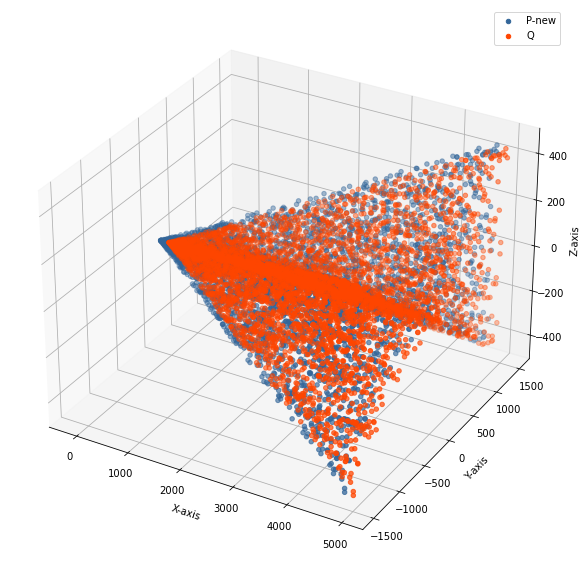

In [34]:
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()

### Point to plane
### Final Allignment

Iteration: 100%|██████████| 20/20 [47:58<00:00, 143.95s/it]


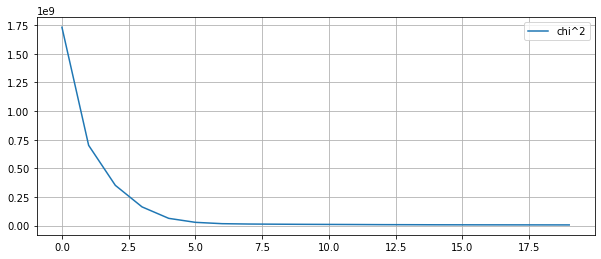

[1731402675.7064035, 700423988.5574062, 351158524.89123696, 163080011.09967256, 63050586.57550446, 28189867.783047546, 16535961.50566919, 13449757.945686357, 12060776.776985055, 10873109.357349843, 10039962.256785521, 9170100.829247287, 8119951.666700051, 7651722.566706326, 6978097.903679675, 6652920.783048723, 6424421.21713713, 6229763.6593750315, 5988321.894350105, 5754730.05316176]


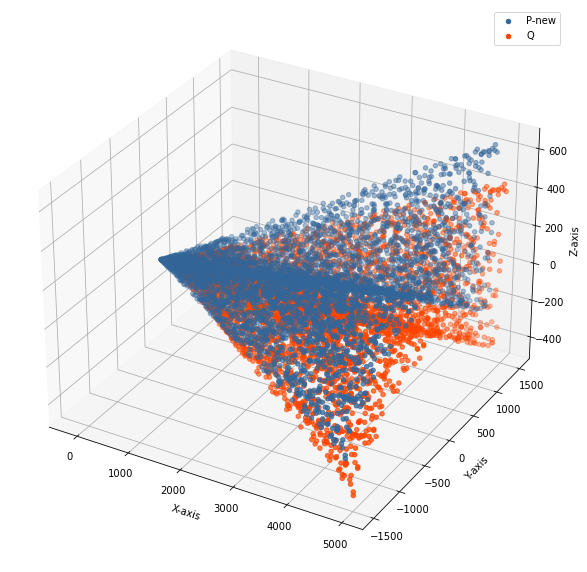

In [35]:
normals, normals_to_draw = compute_normals(Q)

P_values, chi_values, corresp_values = icp_normal(P, Q, normals)
plot_values(chi_values, label="chi^2")
print(chi_values)
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()